<a href="https://colab.research.google.com/github/albercej/zug/blob/master/notebooks/How_you_can_use_Python_to_find_the_top_ten_momentum_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How you can use Python to find the top ten momentum stocks efficiently     
Here is a step by step guide to a process I run each month to choose my next potential momentum<sup>1</sup> based investment. Of course, this is not investment advice, and I’m not guaranteeing you will make money, but it is an easy and quick way to access share price information for analysis. The process was born out of frustration that I could not find a simple, reliable league table of the fastest-growing shares in an online sea of information. The code presented here is designed to load and run online in a Google Collaboratory notebook<sup>2</sup>, so you can get away with not knowing or caring how to run Python - scroll to the end and press the "open in colab" button.  And if you have not used Python to analyse data before - welcome to the new World! It's possible to do all this online without having a high powered computer or spending hours downloading and configuring software<sup>9</sup>. If you aready use Jupyter notebooks you can download and run this one from my [Github](https://github.com/ant358/ColabGitHub/blob/main/notebooks/How_you_can_use_Python_to_find_the_top_ten_momentum_stocks.ipynb)  


## First, find out what stocks available to trade      
Download the available share data. 
I use Freetrade as a broker; at the time of writing, the Freetrade available stock list was on this [page](   
https://freetrade.io/stock-list#stock-list-table). And the data itself is stored in a [spreadsheet](  
https://docs.google.com/spreadsheets/d/14Ep-CmoqWxrMU8HshxthRcdRW8IsXvh3n2-ZHVCzqzQ/edit#gid=1855920257)
 
Of course, these links may change; therefore, edit the link in the code cell below if it is broken. Or, if you use a different broker, find their listings. The goal here is to have a list of stocks symbols to evaluate!

 

In [1]:
# import the Python modules and packages required
import pandas as pd
import numpy as np
import io
import requests
import pprint
import matplotlib.pyplot as plt

The stock listings link above is for a multitab Google docs spreadsheet. However, we only need one tab so, there is a bit of work to adjust the link and get only the sheet we need<sup>3</sup>.

In [2]:
# the freetrade file link
link = "https://docs.google.com/spreadsheets/d/14Ep-CmoqWxrMU8HshxthRcdRW8IsXvh3n2-ZHVCzqzQ/edit#gid=1855920257"
# split the link after /edit - keep just the first part
url_start = link.split('/edit')[0]
# add the sheet name
sheet_name = 'Freetrade Universe'
url_end = f"/gviz/tq?tqx=out:csv&sheet={sheet_name}"
# build the new link
url = url_start + url_end
# show the new url
url

'https://docs.google.com/spreadsheets/d/14Ep-CmoqWxrMU8HshxthRcdRW8IsXvh3n2-ZHVCzqzQ/gviz/tq?tqx=out:csv&sheet=Freetrade Universe'

The Python Requests<sup>4</sup> library makes it easy to grab data from websites, so we will use that to get the spreadsheet URL and Pythons' StringIO<sup>5</sup> to knock the data into a readable format<sup>6</sup>.

In [3]:
# use python requests package to get the file
file = requests.get(url).content
# use python io to read the file into a pandas dataframe 
df = pd.read_csv(io.StringIO(file.decode('utf-8')))
# view the first 5 lines
df.head()

,Title,Long_Title,Subtitle,Currency,ISA_eligible,SIPP_eligible,ISIN,MIC,Symbol,Fractional_Enabled,PLUS_only,for_Ireland_investors,for_Netherlands_investors,KIID_URL,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,MGC Pharmaceuticals,MGC Pharmaceuticals Limited,Phytocannabinoid,gbp,True,True,AU000000MXC6,XLON,MXC,False,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tirupati Graphite,Tirupati Graphite plc,Flake graphite,gbp,True,True,GB00BFYMWJ95,XLON,TGR,False,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wise,Wise Plc,Cross-border payments,gbp,True,True,GB00BL9YR756,XLON,WISE,False,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Darktrace,Darktrace plc,Cybersecurity,gbp,True,True,GB00BNYK8G86,XLON,DARK,False,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Petershill Partners,Petershill Partners Plc,Investment group,gbp,True,True,GB00BL9ZF303,XLON,PHLL,False,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Next, filter the data frame of stocks for your account circumstances  
When you look at the columns in the data, there are some boolean (True/False) columns to filter the stocks, e.g. my investments are held in a UK ISA for tax efficiency, I am not a Plus subscriber, and I like being able to buy Fractional shares. So I need to choose only the True rows to filter the number of shares as follows.  

In [4]:
# how many shares are there to start with?
print('Number of shares available: ',len(df))
# choose only the ISA eligible ones
df = df[df['ISA_eligible']==True]
# whats left?
print('Number of shares available: ',len(df))

Number of shares available:  5568
Number of shares available:  5139


In [5]:
# deselect the Plus account only shares
df = df[df['PLUS_only']==False]
print('Number of shares available: ',len(df))

Number of shares available:  4029


In [6]:
# make sure they can be traded fractionally
df = df[df['Fractional_Enabled']==True]
print('Number of available: ',len(df))

Number of available:  3392


## Now clean up the spreadsheet   
Drop the other columns and keep a few useful ones for reference information.      
1) [ISIN](https://en.wikipedia.org/wiki/International_Securities_Identification_Number ) - this is a unique identifier for all stocks Worldwide   
2) [MIC](https://www.iso20022.org/market-identifier-codes) - this is an identifier for the exchange the stocks are traded on  
3) Subtitle - looks like the market sector  
4) Symbol is the market ticker  
5) The title, long title and account currency  

In [7]:
# Copy to a new dataframe and keep only the useful columns
tradeable = df[['Title', 'Long_Title', 'Subtitle', 'Currency', 'ISIN', 'MIC', 'Symbol']].copy()

## Time to get the share price data from the internet?
Many sites provide comprehensive share price data; can we use Python to grab and collate this data from the internet painlessly?  
First stop Yahoo Finance<sup>7</sup>, and there is a python module to work with that data called yfinance<sup>8</sup>. yfinance does not come preinstalled in google colab notebooks by default, so we will check if the module can be imported and, if not - install it.  

In [8]:
# import yfinance or install it first
try: 
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

     |████████████████████████████████| 6.3 MB 6.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=f80a15428f39d682e4152e93ad11169a0de8058d04ffabbfd3f86ef45fadd1fa
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Clean up the data  
Have we got unique tickers for all the instruments? I already know there are some duplicates in the sheet so we will drop those.  

In [9]:
# drop the duplicates
tradeable.drop_duplicates(subset='Symbol', keep='first', inplace=True)

## Time to collect the historical share price data  
Now we can use yfinance to collect the daily price data for every ticker in our list for the last three months. Depending on the number of shares in the ticker list(currently ~3400) and the internet speed, this will take about ten minutes. It collects the open, high, low, close and volume data. We are only going to use the adjusted close, with the auto_adjust set to True. The data frame called share data can be saved and used for other analysis if you want to explore it further; simply add a line `share_data.to_csv('share_data.csv')`.     

In [10]:
%timeit
# use yfinance to collect the data
share_data = yf.download(tradeable.Symbol.to_list(),
                         period="3mo", 
                         interval="1d", 
                         auto_adjust=True, 
                         back_adjust=True,
                         prepost=True)

[*********************100%***********************]  3390 of 3390 completed

13 Failed downloads:
- OIBR.C: No data found, symbol may be delisted
- CWEN.A: No data found, symbol may be delisted
- FTIV: No data found, symbol may be delisted
- LGF.B: None
- LEN.B: None
- IPOC: None
- BF.A: No data found, symbol may be delisted
- BF.B: None
- BRK.B: No data found, symbol may be delisted
- PBR.A: No data found, symbol may be delisted
- HEI.A: No data found, symbol may be delisted
- JW.A: No data found, symbol may be delisted
- LGF.A: No data found, symbol may be delisted


In [11]:
# select just Apple from the multiindex to eyeball data
share_data.xs('AAPL', axis=1, level=1).head()
# unquote line below to save all in GDrive/Colab Notebooks
# share_data.to_csv('share_data.csv')

,Close,High,Low,Open,Volume
Date,,,,,
2021-07-19,NaN,NaN,NaN,NaN,NaN
2021-07-20,145.931351,146.879942,142.746136,143.245388,96350000.0
2021-07-21,145.182480,145.911399,144.413643,145.312290,74993500.0
2021-07-22,146.580383,147.978283,145.591859,145.721669,77338200.0
2021-07-23,148.337753,148.497518,146.700207,147.329270,71447400.0


## Data Wrangling    
For calculating the growth, we only need the daily close price. And then, to compare all of the stocks to each other, we can calculate the percentage change from one daily close to the next. 

In [12]:
# select the close column for each ticker
data_close = share_data['Close']
# calculate the daily percentage change
data_returns = data_close.pct_change(1)
# eyeball the data 
data_returns.head()
# there are normally NaN in the first couple of rows

,A,AA,AAC,AAL,AAN,AAP,AAPL,AAQC,AAT,ABB,ABBV,ABC,ABCL,ABEO,ABEV,ABMD,ABNB,ABOS,ABR,ABSI,ABST,ABT,ABTX,ABUS,AC,ACAD,ACAH,ACB,ACBI,ACC,ACCD,ACCO,ACEL,ACET,ACEV,ACGL,ACH,ACHC,ACHR,ACI,...,YI,YMAB,YMM,YNDX,YORW,YOU,YTRA,YUM,YUMC,Z,ZBH,ZBRA,ZD,ZEAL,ZEN,ZENV,ZETA,ZEV,ZGNX,ZI,ZIM,ZION,ZIOP,ZIP,ZIXI,ZM,ZNGA,ZNTE,ZNTL,ZOM,ZS,ZTS,ZUO,ZVIA,ZVO,ZWRK,ZWS,ZY,ZYME,ZYNE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-21,NaN,0.061230,NaN,NaN,NaN,NaN,-0.005132,NaN,NaN,0.020501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005068,NaN,0.008023,NaN,0.022727,NaN,NaN,-0.021847,0.000000,0.031550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.070556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004894,NaN
2021-07-22,0.009063,0.003775,0.0,-0.011215,-0.040718,0.00425,0.009629,0.000413,-0.019241,0.005022,0.004701,0.013703,-0.035499,-0.022222,-0.015337,0.002137,0.001580,-0.002330,-0.015126,NaN,-0.010130,-0.006136,-0.029167,-0.044218,-0.030374,-0.063211,0.001037,-0.041223,-0.018977,-0.006173,-0.020604,-0.012376,-0.00945,0.022444,0.000000,-0.009096,0.040523,-0.013873,0.001013,-0.034004,...,-0.028796,-0.011412,-0.085145,0.001862,-0.003164,0.031791,0.005155,0.029888,0.008284,-0.009224,-0.005703,0.004590,-0.007416,0.015187,0.019161,NaN,0.061157,-0.045070,-0.018782,0.020825,-0.028014,-0.025562,-0.041667,0.000000,0.004167,0.023855,-0.009578,-0.000998,-0.021546,-0.044073,0.019605,0.012624,-0.001151,NaN,0.076923,0.001244,-0.004530,0.019438,-0.022727,-0.035343
2021-07-23,0.013373,-0.004566,0.0,0.001890,-0.018345,0.02216,0.011989,-0.001136,-0.003542,0.018878,0.005530,0.012266,-0.014972,-0.007576,-0.006231,0.015392,-0.005306,-0.002919,0.006826,0.060213,0.010965,0.021565,0.010873,-0.017794,0.000268,-0.034638,0.000000,-0.018031,0.015980,0.008215,-0.000409,0.008772,0.00000,-0.008537,0.001015,0.010490,-0.025754,0.007361,0.000000,0.008470,...,-0.074124,0.019625,-0.283828,0.005863,0.009099,-0.011267,-0.025641,0.021038,0.006542,0.009130,0.008257,0.023106,0.016563,-0.027593,0.026698,0.0,-0.032710,-0.036873,0.033643,0.007674,-0.027020,0.010731,-0.026087,0.025462,0.001383,-0.005977,0.010638,0.000999,0.030101,-0.001590,0.013286,0.015209,0.016715,0.008791,0.035714,-0.000207,0.000758,0.027312,-0.018826,-0.028017


## Data Wrangling (II)  
Sometimes stock splits do not get calculated properly into the adjusted close price and I like to get rid of any stocks that jumped to far in a single day. For example when a biotech gets positive clinical trial results and I have missed the boat!. So, next step is to drop any rows that grew by more than 50% in a day. The threshold value can be adjusted below.

In [13]:
# set the growth theshold
daily_growth_threshold = 0.5
# keep only the columns without a daily growth that big
data_returns = data_returns.loc[:, ~(data_returns >=daily_growth_threshold).any()]

## Data Calculations    
Next, it’s time to calculate the cumulative percentage growth of the share price. Unfortunately, you can't just add percentages up but apply them to 1 first, calculate the product, and take the 1 away again.   
e.g. if the stock grew 5% one day and 3% the previous day $$(1 + 0.05) * (1 + 0.03) = (1.0815 - 1)$$  So 8.15% not 8%. Fortunately this is easy to do on a large data set using Python! 

In [14]:
# calculate the cumulative daily growth
data_cum_returns = (1 + data_returns).cumprod() -1

## The Current Top Ten  
Results time! Print out a table and charts for the current top ten.

In [15]:
# take the last row
latest = data_cum_returns.tail(1).T.mul(100)
# label the column
latest.columns = ['% change']
# show the top ten
topten = round(latest.sort_values(by='% change', ascending=False)[:10], 2)
topten

,% change
UPST,208.08
AMR,159.90
AFRM,156.23
METC,145.01
TASK,131.60
MARA,115.12
LEU,114.49
CAR,105.91
SD,104.26
LC,103.49


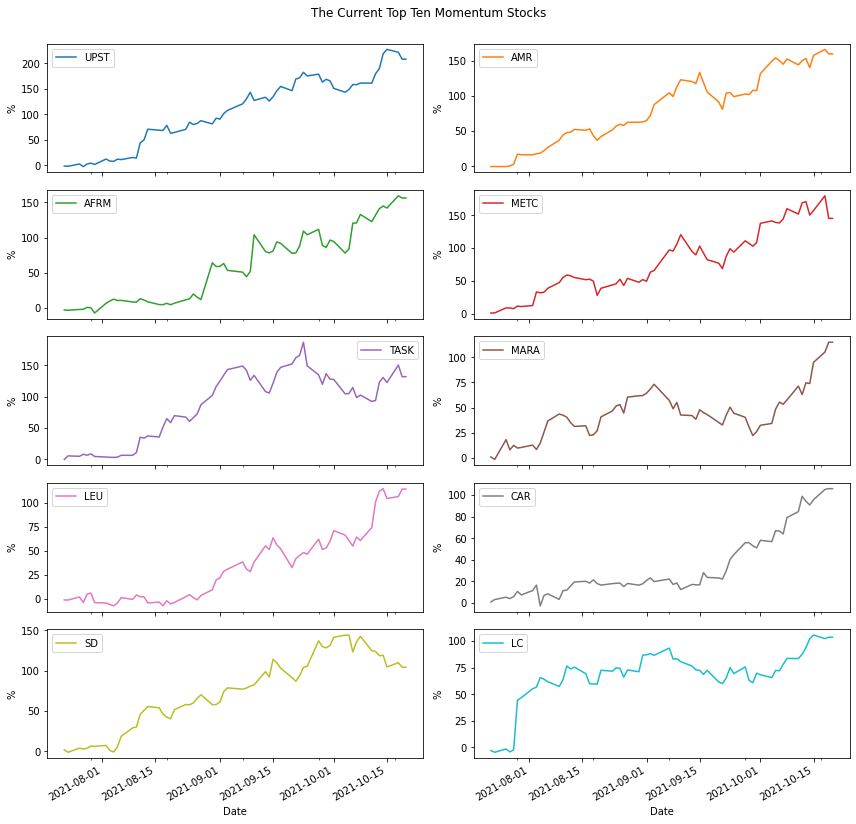

In [16]:
# plot the current top ten
data_cum_returns[list(topten.index)].mul(100).plot(subplots=True, 
                                          layout=(5, 2), 
                                          figsize=(12,12),
                                          sharex=True,
                                          ylabel='%',
                                          title='The Current Top Ten Momentum Stocks')
# tweek the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Getting Further Company Information  
Looks promising! You probably don't want to choose stocks based on a price chart alone. Fortunately, it is quick and easy to scrape far more information than price alone using yfinance. For each ticker in the top ten, we can get lots of financial and company information and drop it into a spreadsheet for further reading.  

In [17]:
# get further information
topten_info = {}
for i in topten.index:
    topten_info[i] = yf.Ticker(i).info
# add the information to a data frame    
info_df = pd.DataFrame.from_dict(topten_info,orient='index')
# add the growth data
info_df['Growth'] = topten
# rank the companies by growth rate
info_df.sort_values(by=['Growth'], ascending=False, inplace=True)
info_df.head()

,zip,sector,fullTimeEmployees,longBusinessSummary,city,phone,state,country,companyOfficers,website,maxAge,address1,industry,address2,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,targetLowPrice,recommendationKey,grossProfits,freeCashflow,targetMedianPrice,currentPrice,earningsGrowth,currentRatio,returnOnAssets,numberOfAnalystOpinions,targetMeanPrice,debtToEquity,returnOnEquity,targetHighPrice,totalCash,totalDebt,totalRevenue,totalCashPerShare,financialCurrency,...,open,averageVolume10days,expireDate,algorithm,dividendRate,exDividendDate,circulatingSupply,startDate,regularMarketDayLow,currency,regularMarketVolume,lastMarket,maxSupply,openInterest,marketCap,volumeAllCurrencies,strikePrice,averageVolume,dayLow,ask,askSize,volume,fiftyTwoWeekHigh,fromCurrency,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,tradeable,dividendYield,bidSize,dayHigh,regularMarketPrice,preMarketPrice,logo_url,lastDividendDate,impliedSharesOutstanding,toCurrency,trailingPE,fax,Growth
UPST,94403,Financial Services,554,"Upstart Holdings, Inc. operates a cloud- based...",San Mateo,650 204 1000,CA,United States,[],http://www.upstart.com,1,2950 South Delaware Street,Credit Services,Suite 300,0.11858,0.04925,0.84436,145311008,0.820,0.10988,35166000,160.00,buy,203861000,NaN,230.0,367.08,0.087,8.135,NaN,7.0,234.00,18.875,NaN,300.0,257016992,60512000,296568000,3.342,USD,...,388.3100,5562885,None,None,None,NaN,None,None,362.88,USD,4634205,None,None,None,28229992448,None,None,5119001,362.88,364.90,1200,4634205,401.490,None,None,22.61,364.21,False,None,900,394.98,367.08,365.10,https://logo.clearbit.com/upstart.com,NaN,NaN,NaN,NaN,NaN,208.08
AMR,37620,Basic Materials,3300,"Alpha Metallurgical Resources, Inc. operates a...",Bristol,423 573 0300,TN,United States,[],http://www.alphametresources.com,1,340 Martin Luther King Jr. Boulevard,Coking Coal,NaN,0.08244,-0.15317,0.09386,24847000,0.117,-0.00756,118797000,38.00,hold,135176000,4902625.0,38.0,62.35,NaN,1.715,-0.00368,1.0,38.00,357.089,-0.61153,38.0,72337000,579667008,1440971008,3.931,USD,...,64.4500,217600,None,None,None,1.498781e+09,None,None,58.95,USD,218252,None,None,None,1146616448,None,None,286386,58.95,0.00,800,218252,66.040,None,None,11.13,61.40,False,None,4000,64.50,62.35,NaN,https://logo.clearbit.com/alphametresources.com,NaN,NaN,NaN,NaN,NaN,159.90
AFRM,94108,Technology,1641,"Affirm Holdings, Inc. operates a platform for ...",San Francisco,415 984 0490,CA,United States,[],http://www.affirm.com,1,650 California Street,Information Technology Services,NaN,-0.32002,-0.49505,0.49562,-193130000,0.707,-0.42236,-278567008,65.00,buy,431419000,-166142624.0,110.0,155.35,NaN,18.230,-0.07330,13.0,117.69,76.799,-0.28555,160.0,1466557952,1982306048,870464000,5.394,USD,...,157.5174,22561557,None,None,None,NaN,None,None,153.30,USD,12814502,None,None,None,42235785216,None,None,12037070,153.30,155.45,1200,12814502,160.690,None,None,46.50,155.01,False,None,1200,160.60,155.35,155.25,https://logo.clearbit.com/affirm.com,NaN,271875008.0,NaN,NaN,NaN,156.23
METC,40507,Basic Materials,349,"Ramaco Resources, Inc. produces and sells meta...",Lexington,859 244 7455,KY,United States,[],http://www.ramacoresources.com,1,250 West Main Street,Coking Coal,Suite 1800,0.07356,0.02172,0.17478,39401000,1.091,-0.03650,15457000,5.25,buy,23412000,20509624.0,11.0,14.48,2.750,1.565,-0.01960,5.0,10.25,7.254,0.02522,13.0,19394000,13451000,210116000,0.440,USD,...,16.7800,586985,None,None,None,NaN,None,None,14.27,USD,960803,None,None,None,638704064,None,None,352898,14.27,0.00,1800,960803,17.430,None,None,2.67,14.41,False,None,800,17.43,14.48,14.85,https://logo.clearbit.com/ramacoresources.com,NaN,NaN,NaN,146.26262,NaN,145.01
TASK,78132,Technology,31500,"TaskUs, Inc. provides outsourcing services for...",New Braunfels,888 400 8275,TX,United States,[],http://www.taskus.com,1,1650 Independence Drive,Information Technology Services,Suite 100,0.23726,-0.10844,0.44964,81947000,0.574,0.16754,140956992,37.00,buy,21

In [18]:
# which sectors are hot?
info_df['sector'].value_counts()

Financial Services    3
Technology            2
Basic Materials       2
Energy                2
Industrials           1
Name: sector, dtype: int64

## Save the information 
Okay thats it - job done. It's possible to output the information table to Google Drive it normally lands in a folder called Colab Notebooks if you have run this online.

In [19]:
# save the spreadsheet for further reading
info_df.to_csv('growth_shares_info.csv')

## References
<a href="https://colab.research.google.com/github/ant358/ColabGitHub/blob/main/notebooks/How_you_can_use_Python_to_find_the_top_ten_momentum_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
1. [Momentum Trading](https://en.wikipedia.org/wiki/Momentum_investing)
2. [Google Colab](https://colab.research.google.com/)
3. [Read data from Google Sheets](https://towardsdatascience.com/read-data-from-google-sheets-into-pandas-without-the-google-sheets-api-5c468536550)  
4. [Python Requests](https://docs.python-requests.org/en/latest/)
5. [StringIO](https://docs.python.org/3/library/io.html)  
6. [Read a CSV from an URL](https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url)     
7. [Using Yahoo Finance](https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e)   
8. [yfinance](https://pypi.org/project/yfinance/)  